# Training Convergence Plots for Learning Punctuation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
print(os.getcwd())
import time
import gc
import torch
import bisect

from conv_plots_funcs import train_conv_plots

#import empirical cdf
# import sys
# sys.path.append(os.path.abspath('../../src'))

from data_processing import gen_ckpt_steps, move_dict_to_device, get_other_err, get_mop_ratios_ckpt, compute_ratio
# sys.path.append(os.path.abspath('..'))

from check_ecdf import get_empirical_cdf

/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
Using device: cuda


In [2]:
valA = "gaussA"
valC = "_gauss_C"
state_dim = 10
ckpt_step = 8
experiment = "250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"

num_test_trace_configs = 10

compute_more_ckpts = False

In [3]:
# create a list called ckpts that goes from min to max in steps of 3000
min_ckpt = 3000
max_ckpt = 1002000
ckpt_interval = 3000
ckpts = gen_ckpt_steps(min_ckpt, max_ckpt, ckpt_interval)

        
    

ckpt_steps: [3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000, 30000, 33000, 36000, 39000, 42000, 45000, 48000, 51000, 54000, 57000, 60000, 63000, 66000, 69000, 72000, 75000, 78000, 81000, 84000, 87000, 90000, 93000, 96000, 99000, 102000, 105000, 108000, 111000, 114000, 117000, 120000, 123000, 126000, 129000, 132000, 135000, 138000, 141000, 144000, 147000, 150000, 153000, 156000, 159000, 162000, 165000, 168000, 171000, 174000, 177000, 180000, 183000, 186000, 189000, 192000, 195000, 198000, 201000, 204000, 207000, 210000, 213000, 216000, 219000, 222000, 225000, 228000, 231000, 234000, 237000, 240000, 243000, 246000, 249000, 252000, 255000, 258000, 261000, 264000, 267000, 270000, 273000, 276000, 279000, 282000, 285000, 288000, 291000, 294000, 297000, 300000, 303000, 306000, 309000, 312000, 315000, 318000, 321000, 324000, 327000, 330000, 333000, 336000, 339000, 342000, 345000, 348000, 351000, 354000, 357000, 360000, 363000, 366000, 369000, 372000, 375000, 378000, 381000, 384000,

/home/sultand/TFs_do_KF_ICL/outputs/train_conv/training_dist_comparison_val_gaussA_state_dim_10_val_sys_10_1737352265.5638435.png
ckpt_steps: [3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000, 30000, 33000, 36000, 39000, 42000, 45000, 48000, 51000, 54000, 57000, 60000, 63000, 66000, 69000, 72000, 75000, 78000, 81000, 84000, 87000, 90000, 93000, 96000, 99000, 102000, 105000, 108000, 111000, 114000, 117000, 120000, 123000, 126000, 129000, 132000, 135000, 138000, 141000, 144000, 147000, 150000, 153000, 156000, 159000, 162000, 165000, 168000, 171000, 174000, 177000, 180000, 183000, 186000, 189000, 192000, 195000, 198000, 201000, 204000, 207000, 210000, 213000, 216000, 219000, 222000, 225000, 228000, 231000, 234000, 237000, 240000, 243000, 246000, 249000, 252000, 255000, 258000, 261000, 264000, 267000, 270000, 273000, 276000, 279000, 282000, 285000, 288000, 291000, 294000, 297000, 300000, 303000, 306000, 309000, 312000, 315000, 318000, 321000, 324000, 327000, 330000, 333000, 33600

(array([3.6507463, 3.6507463, 3.6507463], dtype=float32),
 [3000,
  6000,
  9000,
  12000,
  15000,
  18000,
  21000,
  24000,
  27000,
  30000,
  33000,
  36000,
  39000,
  42000,
  45000,
  48000,
  51000,
  54000,
  57000,
  60000,
  63000,
  66000,
  69000,
  75000,
  81000,
  84000,
  90000,
  93000,
  96000,
  99000,
  102000,
  105000,
  108000,
  111000,
  114000,
  117000,
  120000,
  123000,
  126000,
  129000,
  132000])

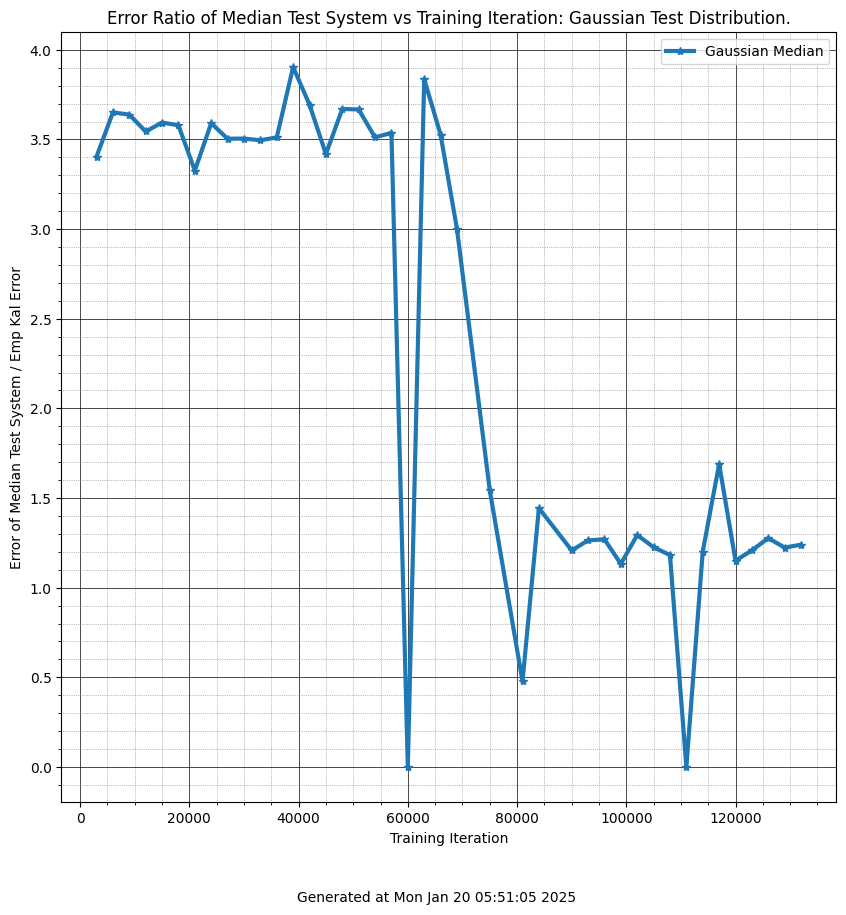

In [3]:
kal_ckpt = 81000
train_conv_plots([experiment], ["Gaussian"], [kal_ckpt], "gaussA", "_gauss_C", 10, True, None, 3000, 1002000, 3000, state_dim, single_system=True)